In [74]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [75]:
#Essentials
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import pickle 

#sklearn "magic"
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline

#Oversampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


#Not sure about these ones yet
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

#Different scores
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score, roc_curve

#Nice to have
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from ipywidgets import interactive, FloatSlider
from collections import Counter
#interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

#Let there be colours!
from termcolor import colored

%matplotlib inline

In [76]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [77]:
# Postgres info to connect

connection_args = {
    'host': '18.222.192.127', 
    'user': 'ubuntu',    # username
    'dbname': 'student_grades',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [78]:
# failures: 0.205
# discipline: 0.116
# absences: 0.081
# higher: 0.052
# goout: 0.051
# Fedu: 0.049
# Medu: 0.043
# studytime: 0.037
# famrel: 0.035
# Walc: 0.035
# age: 0.034
# freetime: 0.032
# paid: 0.029
# health: 0.029
# address: 0.025

In [79]:
### Let's combine the two SQL tables into one

append_query = """SELECT *
                    
                    FROM maths_grades
                    WHERE age BETWEEN 15 AND 19

                    UNION ALL

                    SELECT *
                    
                    FROM portuguese_grades
                    WHERE age BETWEEN 15 AND 19
                    """

grades = pd_sql.read_sql(append_query, connection)

In [80]:
grades.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,guardian,traveltime,studytime,...,freetime,goout,Dalc,Walc,health,absences,G3,discipline,final_grade_label,final_grade_segment
0,F,18,U,GT3,A,4,4,mother,2,2,...,3,4,1,1,3,6,6,maths,Fail,Fail
1,F,17,U,GT3,T,1,1,father,1,2,...,3,3,1,1,3,4,6,maths,Fail,Fail
2,F,15,U,LE3,T,1,1,mother,1,2,...,3,2,2,3,3,10,10,maths,Pass,Sufficient
3,F,15,U,GT3,T,4,2,mother,1,3,...,2,2,1,1,5,2,15,maths,Pass,Good
4,F,16,U,GT3,T,3,3,father,1,2,...,3,2,1,2,5,4,10,maths,Pass,Sufficient


### Feature and target analysis

In [81]:
print(grades['final_grade_label'].value_counts(), '\n')
print('% of Pass:', str(round(814 / 1044, 2)))
print('% of Fail:', str(round(230 / 1044, 2)), '\n')
print('Pass to Fail ratio in the dataset:', str(int((814 / 1044)*100))+':'+str(int((230 / 1044)*100)))
print('Percentage of Majority grade (Pass)', str(round((814 / 1044) *100, 0)))

Pass    804
Fail    226
Name: final_grade_label, dtype: int64 

% of Pass: 0.78
% of Fail: 0.22 

Pass to Fail ratio in the dataset: 77:22
Percentage of Majority grade (Pass) 78.0


> **This is not good!** I should look into oversampling or undersampling further down the line

### Let's dummify some variables

In [82]:
#Sanity check
grades.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'G3', 'discipline', 'final_grade_label', 'final_grade_segment'],
      dtype='object')

In [83]:
#dummify sex (M=0, F=1)
grades['sex'].replace({'M': 0, 'F': 1}, inplace=True)

#dummify address (U(urban)=0, R(rural)=1)
grades['address'].replace({'U': 0, 'R': 1}, inplace=True)

#dummify discipline (maths=0, portuguese=1)
grades['discipline'].replace({'maths': 0, 'portuguese': 1}, inplace=True)

#dummify target variable
grades['final_grade_label'].replace({'Fail': 0, 'Pass': 1}, inplace=True)

#drop unimportant columns (including G3, which is the actual grade)
grades.drop(columns=['G3', 'sex', 'romantic', 'guardian', 'Dalc', 'activities', 'schoolsup', 'traveltime', 'famsup',
                    'famsize', 'internet', 'Pstatus', 'final_grade_segment'], inplace=True)

# #dummify famsize (LE3(less than/equal to 3)=0, GT3(greater than 3)=1)
# grades['famsize'].replace({'LE3': 0, 'GT3': 1}, inplace=True)

# #dummify Pstatus(parent status) (T(together)=0, A(apart)=1)
# grades['Pstatus'].replace({'T': 0, 'A': 1}, inplace=True)

# #dummify guardian (other=0, mother=1, father=2)
# grades['guardian'].replace({'other': 0, 'mother': 1, 'father': 2}, inplace=True)

In [84]:
feat, grade_label = grades.iloc[:, :-1], grades.iloc[:, -1]

In [85]:
# print(feat.head())
# print(grade_label.head())

In [86]:
#grades.corr()

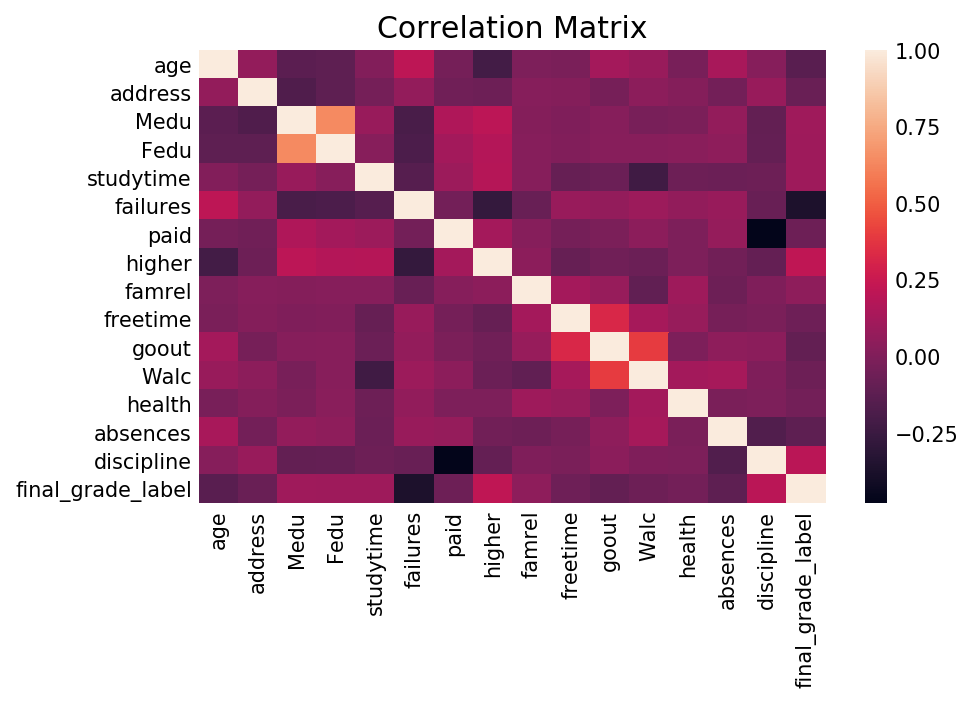

In [87]:
plt.figure(dpi=150)
plt.title('Correlation Matrix')
corr = grades.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

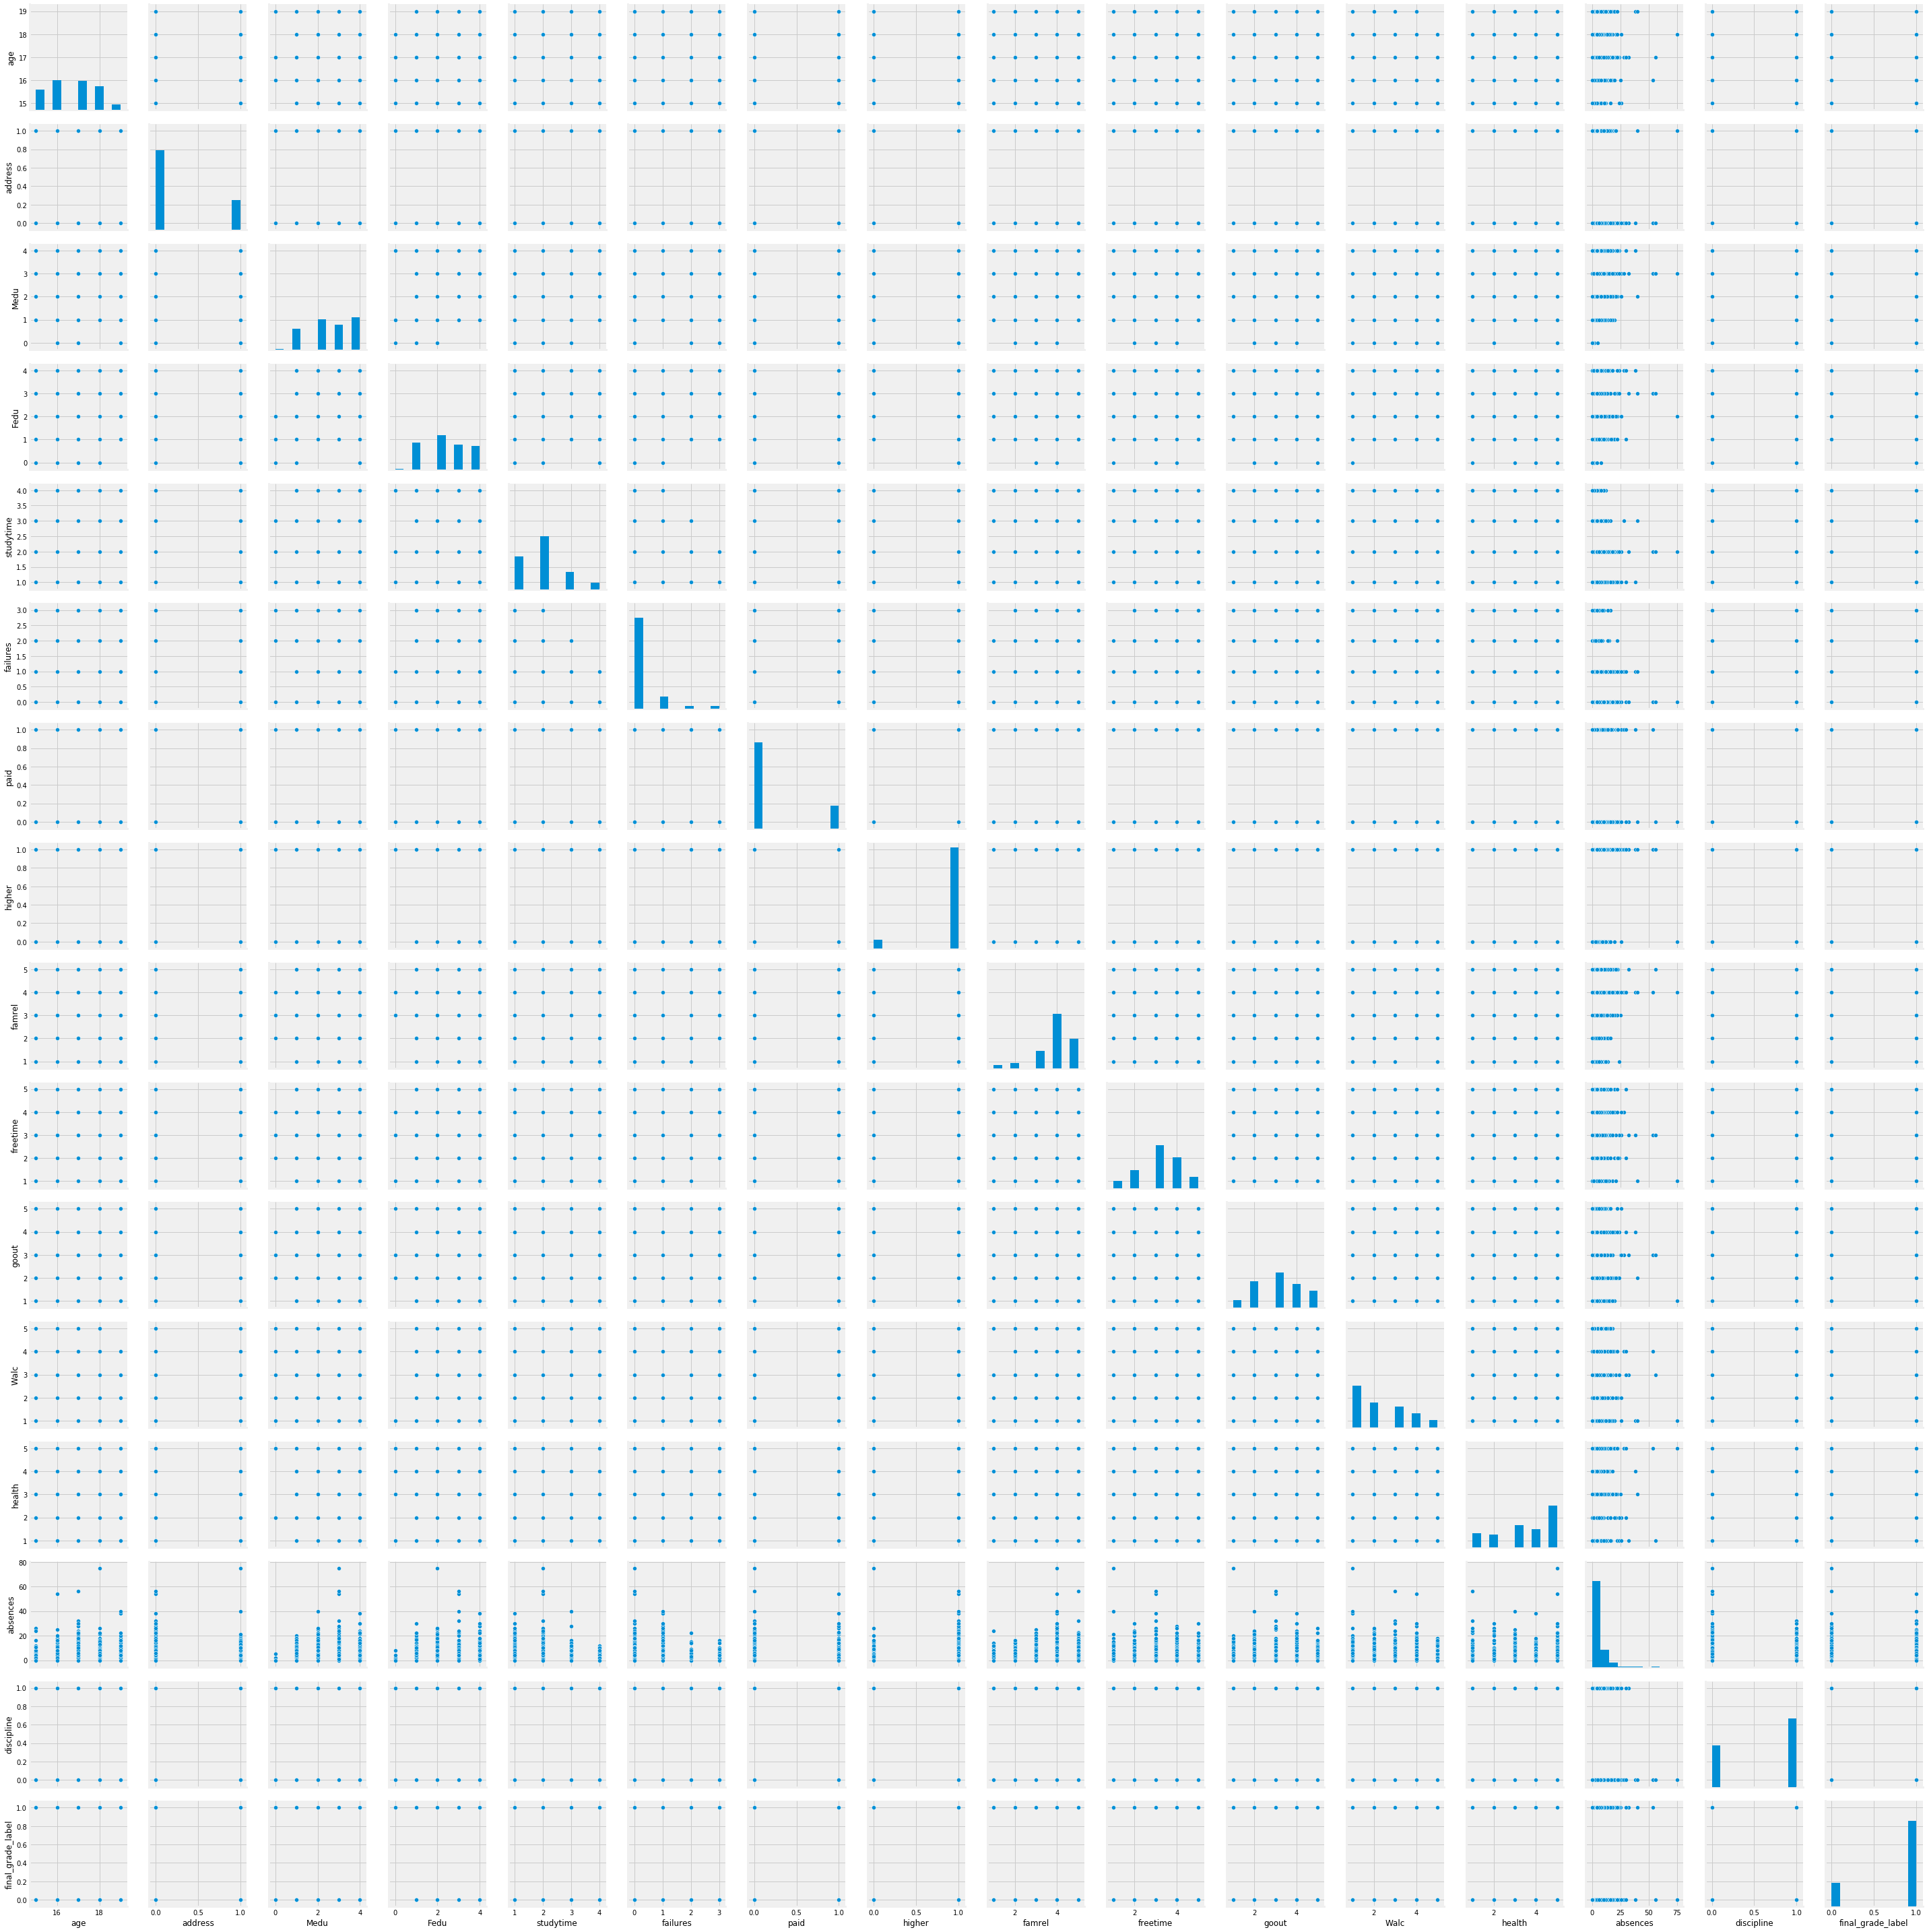

In [88]:
sns.pairplot(grades);


## Train - test split

In [89]:
feat_train, feat_test, grade_label_train, grade_label_test = train_test_split(feat, grade_label, test_size=0.2
                                                                                  , random_state=42, stratify=grade_label)

# Modelling Time

### Identifying best hyper-parameters

**KNN Classifier (in search for the optimal k)**

In [90]:
k_range = range(1, 31)
weight_options = ['uniform', 'distance']
param_grid_knn = dict(n_neighbors=k_range, weights=weight_options)

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='precision')
grid_knn.fit(feat_train, grade_label_train);

In [91]:
# examine the best model
print('Best precision score for knn cross validation is', colored(str(round(grid_knn.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for knn cross validation are', colored(str(grid_knn.best_params_), 'magenta')+ '.')
print('Best estimators for knn cross validation are the following:\n\t', colored(str(grid_knn.best_estimator_), 'magenta'))

Best precision score for knn cross validation is 0.806.
Best parameters for knn cross validation are {'n_neighbors': 4, 'weights': 'uniform'}.
Best estimators for knn cross validation are the following:
	 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')


**Logistic Regression Classifier (in search for the optimal hypers)**

In [92]:
penalties = ['l1', 'l2']
C_range = [1e-04, 1e-03, 1e-02, 0.1, 1.0, 10.0]
weights = [None, 'balanced']
iterations = [1, 2, 5, 10, 20, 40, 60]
param_grid_LogReg = dict(penalty=penalties, C=C_range, class_weight=weights, max_iter=iterations)

grid_LogReg = GridSearchCV(LogisticRegression(random_state=42), param_grid_LogReg, scoring='average_precision')
grid_LogReg.fit(feat_train, grade_label_train);

In [93]:
# examine the best model
print('Best avg. precision score for Logistic Regression cross validation is', colored(str(round(grid_LogReg.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Logistic Regression cross validation are:\n\t', colored(str(grid_LogReg.best_params_), 'magenta')+ '.')
print('Best estimators for Logistic Regression cross validation are the following:\n\t', colored(str(grid_LogReg.best_estimator_), 'magenta'))

Best avg. precision score for Logistic Regression cross validation is 0.921.
Best parameters for Logistic Regression cross validation are:
	 {'C': 10.0, 'class_weight': None, 'max_iter': 1, 'penalty': 'l1'}.
Best estimators for Logistic Regression cross validation are the following:
	 LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


**Random Forest Classifier (in search for the optimal hypers)**

In [94]:
estimators = [150] #tried [2, 5, 10, 20, 40, 50, 100, 150]
depth = [20] #tried [2, 5, 10, 20, 30, 40]
leaf_samples = [10] #tried [1, 2, 3, 4, 5, 10]
samples = [2] #tried [2, 3, 4, 5, 10]
weights = ['balanced'] #tried ['balanced', None]
param_grid_RandFor = dict(n_estimators=estimators, max_depth=depth, min_samples_leaf=leaf_samples, min_samples_split=samples, class_weight=weights)

grid_RandFor = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_RandFor, scoring='precision')
grid_RandFor.fit(feat_train, grade_label_train);

In [95]:
# examine the best model
print('Best precision score for Random Forest cross validation is', colored(str(round(grid_RandFor.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Random Forest cross validation are:\n\t', colored(str(grid_RandFor.best_params_), 'magenta'))
print('Best estimators for Random Forest cross validation are the following:\n\t', colored(str(grid_RandFor.best_estimator_), 'magenta'))

Best precision score for Random Forest cross validation is 0.879.
Best parameters for Random Forest cross validation are:
	 {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 150}
Best estimators for Random Forest cross validation are the following:
	 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


**Support Vector Classification (SVC) (in search for the optimal hypers)**

In [96]:
C_range = [0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 15.0] #tried [0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 5.0]
kernel_range = ['poly'] #tried ['linear', 'poly', 'rbf', 'sigmoid']
degree_range = [1] #tried [1, 2, 3, 4, 7]
probs = [True] #tried [True, False]
weights = ['balanced'] #tried ['balanced', None]
param_grid_SVC = dict(C=C_range, kernel=kernel_range, degree=degree_range, probability=probs, class_weight=weights)

grid_SVC = GridSearchCV(SVC(random_state=42), param_grid_SVC, scoring='average_precision')
grid_SVC.fit(feat_train, grade_label_train);

In [97]:
# examine the best model
print('Best precision score for SVC cross validation is', colored(str(round(grid_SVC.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for SVC cross validation are:\n\t', colored(str(grid_SVC.best_params_), 'magenta'))
print('Best estimators for SVC cross validation are the following:\n\t', colored(str(grid_SVC.best_estimator_), 'magenta'))

Best precision score for SVC cross validation is 0.914.
Best parameters for SVC cross validation are:
	 {'C': 3.0, 'class_weight': 'balanced', 'degree': 1, 'kernel': 'poly', 'probability': True}
Best estimators for SVC cross validation are the following:
	 SVC(C=3.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


**Naive Bayes Bernoulli (NBB) (in search for the optimal hypers)**

In [98]:
alphas = [1e-05, 1e-4, 1e-2, 0.1, 1.0, 10.0]
priors = [True, False]
param_grid_NBB = dict(alpha=alphas, fit_prior=priors)

grid_NBB = GridSearchCV(BernoulliNB(), param_grid_NBB, scoring='precision')
grid_NBB.fit(feat_train, grade_label_train);

In [99]:
# examine the best model
print('Best precision score for NBB cross validation is', colored(str(round(grid_NBB.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for NBB cross validation are:\n\t', colored(str(grid_NBB.best_params_), 'magenta'))
print('Best estimators for NBB cross validation are the following:\n\t', colored(str(grid_NBB.best_estimator_), 'magenta'))

Best precision score for NBB cross validation is 0.904.
Best parameters for NBB cross validation are:
	 {'alpha': 1e-05, 'fit_prior': False}
Best estimators for NBB cross validation are the following:
	 BernoulliNB(alpha=1e-05, binarize=0.0, class_prior=None, fit_prior=False)


**Stochastic Gradient Descent (SDG) Classifier (in search for the optimal hypers)**

In [100]:
losses = ['hinge']      #also tried ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', , 'squared_epsilon_insensitive']
penalties = ['l1']             #tried ['l1', 'l2']
alphas = [0.01]                 #tried [1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1.0, 5.0]
iterations = [150]            #previous [5, 10, 50, 150, 150, 200, 500]
l_rates = ['invscaling']         #previous ['constant', 'optimal', 'invscaling']
weights = [None]        #tried [None, 'balanced']
etas = [0.2]                   #tried [0.1, 0.2, 0.5]
param_grid_SGD = dict(loss=losses, penalty=penalties, alpha=alphas, max_iter=iterations, learning_rate=l_rates
                      , class_weight=weights, eta0=etas)

grid_SGD = GridSearchCV(SGDClassifier(random_state=42), param_grid_SGD, scoring='average_precision')
grid_SGD.fit(feat_train, grade_label_train);

In [101]:
# examine the best model
print('Best precision score for Stochastic Gradient Descent cross validation is', colored(str(round(grid_SGD.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Stochastic Gradient Descent cross validation are:\n\t', colored(str(grid_SGD.best_params_), 'magenta'))
print('Best estimators for Stochastic Gradient Descent cross validation are the following:\n\t', colored(str(grid_SGD.best_estimator_), 'magenta'))

Best precision score for Stochastic Gradient Descent cross validation is 0.919.
Best parameters for Stochastic Gradient Descent cross validation are:
	 {'alpha': 0.01, 'class_weight': None, 'eta0': 0.2, 'learning_rate': 'invscaling', 'loss': 'hinge', 'max_iter': 150, 'penalty': 'l1'}
Best estimators for Stochastic Gradient Descent cross validation are the following:
	 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.2, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='hinge', max_iter=150, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)


### Let's compare the models at their best

In [102]:
model_list = [KNeighborsClassifier(n_neighbors=4, weights='uniform'), 
              LogisticRegression(C=10.0, class_weight=None, max_iter=5, penalty='l1', random_state=42),
              RandomForestClassifier(n_estimators=150, class_weight='balanced', max_depth=20, min_samples_leaf=10, min_samples_split=2, random_state=42), 
              SVC(5.0, class_weight='balanced', degree=1, kernel='poly', probability=True), 
              GaussianNB(),
              BernoulliNB(alpha=0.1, fit_prior=False),
              SGDClassifier(loss='hinge', penalty='l1', alpha=0.01, max_iter=150, learning_rate='invscaling'
                      , class_weight=None, eta0=0.2, random_state=42)]

model_names = ['KNN', 'Logistic Regression', 'Random Forest', 'SVC', 'Naive Bayes Gaussian', 'Naive Bayes Bernoulli', 'SGD']

In [103]:
model_auc_scores = []
model_precision_scores = []
model_recall_scores = []
all_models = {}

for i in range(len(model_list)):
    try_model = model_list[i]
    try_model.fit(feat_train, grade_label_train)
    all_models[model_names[i]] = try_model
    cv_roc_auc_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='roc_auc')
    cv_precision_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='precision')
    cv_recall_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='recall')
    model_auc_scores.append((model_names[i], round(np.mean(cv_roc_auc_score), 3)))
    model_precision_scores.append((model_names[i], round(np.mean(cv_precision_score), 3)))
    model_recall_scores.append((model_names[i], round(np.mean(cv_recall_score), 3)))
    
print('AUC scores: ' + colored(str(sorted(model_auc_scores, key=lambda x: x[1], reverse=True)), 'green'))
print('Precision scores: '+ colored(str(sorted(model_precision_scores, key=lambda x: x[1], reverse=True)), 'green'))
print('Recall scores: '+ colored(str(sorted(model_recall_scores, key=lambda x: x[1], reverse=True)), 'green'))

AUC scores: [('Random Forest', 0.792), ('Logistic Regression', 0.783), ('Naive Bayes Bernoulli', 0.779), ('Naive Bayes Gaussian', 0.777), ('SGD', 0.776), ('SVC', 0.769), ('KNN', 0.596)]
Precision scores: [('Naive Bayes Bernoulli', 0.897), ('SVC', 0.893), ('Random Forest', 0.89), ('Naive Bayes Gaussian', 0.851), ('Logistic Regression', 0.821), ('SGD', 0.807), ('KNN', 0.795)]
Recall scores: [('SGD', 0.98), ('Logistic Regression', 0.953), ('Naive Bayes Gaussian', 0.904), ('KNN', 0.879), ('Random Forest', 0.803), ('Naive Bayes Bernoulli', 0.711), ('SVC', 0.669)]


> **Random Forest wins! Runner up is Naive Bayes (Bernoulli distribution)**

## Let's check out AUC scores and ROC curves

In [104]:
#roc_curve function calculates the true positive, false positive and a threshold
#fpr_knn, tpr_knn, thresholds_knn = roc_curve(grade_label_train, all_models['KNN'].predict_proba(feat_train)[:,1])
fpr_LogReg, tpr_LogReg, thresholds_LogReg = roc_curve(grade_label_train, all_models['Logistic Regression'].predict_proba(feat_train)[:,1])
fpr_RandFor, tpr_RandFor, thresholds_RandFor = roc_curve(grade_label_train, all_models['Random Forest'].predict_proba(feat_train)[:,1])
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(grade_label_train, all_models['SVC'].predict_proba(feat_train)[:,1])
fpr_NBG, tpr_NBG, thresholds_NBG = roc_curve(grade_label_train, all_models['Naive Bayes Gaussian'].predict_proba(feat_train)[:,1])
fpr_NBB, tpr_NBB, thresholds_NBB = roc_curve(grade_label_train, all_models['Naive Bayes Bernoulli'].predict_proba(feat_train)[:,1])
#fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(grade_label_train, all_models['SGD'].predict_proba(feat_train)[:,1])

Text(0.5,1,'ROC curve for grade problem')

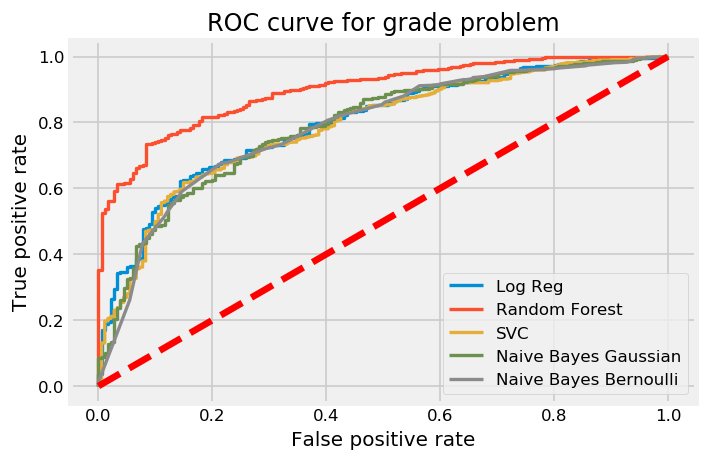

In [236]:
plt.figure(dpi=120, facecolor='white')
#plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN')
plt.plot(fpr_LogReg, tpr_LogReg, lw=2, label='Log Reg')
plt.plot(fpr_RandFor, tpr_RandFor, lw=2, label='Random Forest')
plt.plot(fpr_SVC, tpr_SVC, lw=2, label='SVC')
plt.plot(fpr_NBG, tpr_NBG, lw=2, label='Naive Bayes Gaussian')
plt.plot(fpr_NBB, tpr_NBB, lw=2, label='Naive Bayes Bernoulli')
#plt.plot(fpr_SGD, tpr_SGD, lw=2, label='SGD')
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for grade problem')


#plt.savefig('/Users/auste_m/ds/metis/metisgh/github/metis_projects/Student_Grade_Prediction/ROC.png', format='png', dpi=120, bbox_inches="tight");

>> **It's decided! Random Forest it is!**

In [106]:
#Let's record the two best models
Random_Forest = all_models['Random Forest']

Confusion Matrix for Random Forest


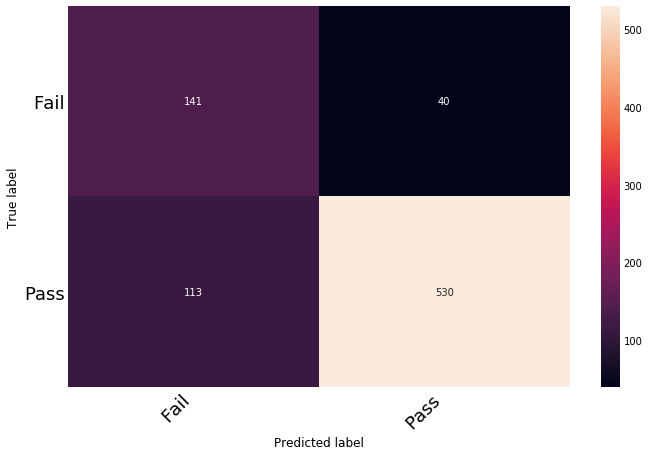

In [107]:
RF_cm = confusion_matrix(grade_label_train, Random_Forest.predict(feat_train))
RF_cm = print_confusion_matrix(RF_cm, ['Fail', 'Pass'])

print('Confusion Matrix for Random Forest')

## Can we do better with oversampling?

#### Random Over Sampler 

In [108]:
ROS = RandomOverSampler(random_state=42)
feat_train_ROS, grade_label_train_ROS = ROS.fit_sample(feat_train, grade_label_train)

In [109]:
Counter(grade_label_train_ROS)

Counter({1: 643, 0: 643})

In [110]:
#Create a new Random Forest model and fit with "oversampled" values
Random_Forest_ROS = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_ROS.fit(feat_train_ROS, grade_label_train_ROS);

The scores on original training set are:

Accuracy score after Random Over Sampler is: 0.808
Recall score after Random Over Sampler is: 0.837
Precision score after Random Over Sampler is: 0.91
F1 score after Random Over Sampler is: 0.872

Confusion Matrix for Random Forest with Random Oversampling


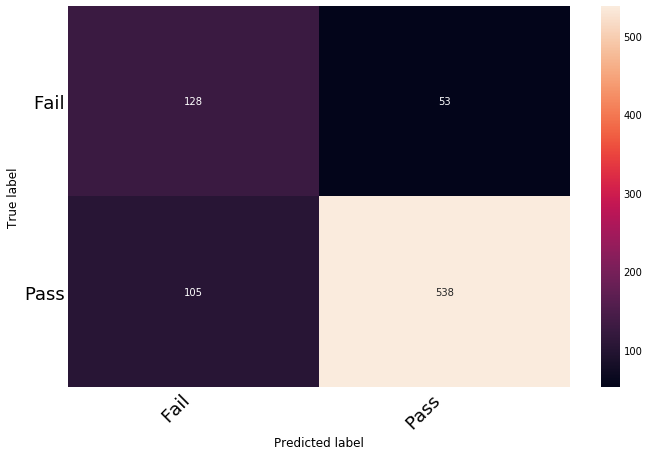

In [111]:
print('The scores on original training set are:\n')
print('Accuracy score after Random Over Sampler is:', colored(str(round(Random_Forest_ROS.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after Random Over Sampler is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))
print('Precision score after Random Over Sampler is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'green'))
print('F1 score after Random Over Sampler is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))

RF_ROS_cm = confusion_matrix(grade_label_train, Random_Forest_ROS.predict(feat_train))
RF_ROS_cm = print_confusion_matrix(RF_ROS_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Random Forest with Random Oversampling')

> Not with Random Over Sampler, apparently!

#### SMOTE

In [112]:
SMO = SMOTE(random_state=42)
feat_train_smoted, grade_label_train_smoted = SMO.fit_sample(feat_train, grade_label_train)

In [113]:
Counter(grade_label_train_smoted)

Counter({1: 643, 0: 643})

In [114]:
Random_Forest_SMOTE = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_SMOTE.fit(feat_train_smoted, grade_label_train_smoted);

Test scores on original training set are:

Accuracy score after SMOTE is: 0.841
Recall score after SMOTE is: 0.899
Precision score after SMOTE is: 0.898
F1 score after SMOTE is: 0.898

Confusion Matrix for Random Forest with SMOTE


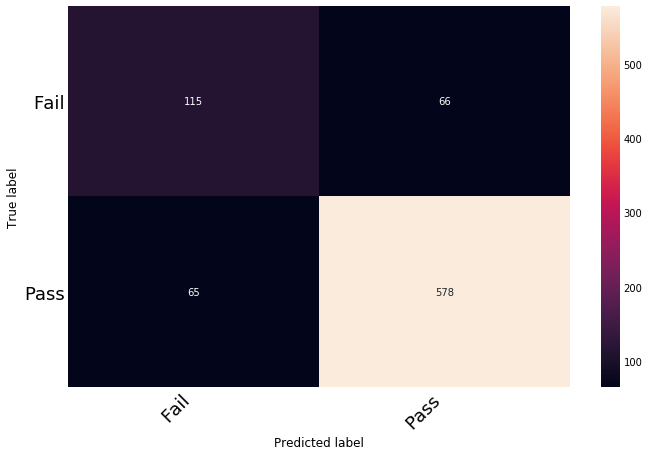

In [115]:
print('Test scores on original training set are:\n')
print('Accuracy score after SMOTE is:', colored(str(round(Random_Forest_SMOTE.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after SMOTE is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))
print('Precision score after SMOTE is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'green'))
print('F1 score after SMOTE is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_smoted_cm = confusion_matrix(grade_label_train, Random_Forest_SMOTE.predict(feat_train))
RF_smoted_cm = print_confusion_matrix(RF_smoted_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Random Forest with SMOTE')

> Not much improvement with SMOTE

#### ADASYN

In [116]:
ADA = ADASYN(random_state=42)
feat_train_adasyn, grade_label_train_adasyn = ADA.fit_sample(feat_train, grade_label_train)

In [117]:
Counter(grade_label_train_adasyn)

Counter({1: 643, 0: 648})

In [118]:
Random_Forest_ADASYN = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn);

Test scores on original training set are:

Accuracy score after ADASYN is: 0.836
Recall score after ADASYN is: 0.9
Precision score after ADASYN is: 0.891
F1 score after ADASYN is: 0.896

Confusion Matrix for Random Forest with ADASYN


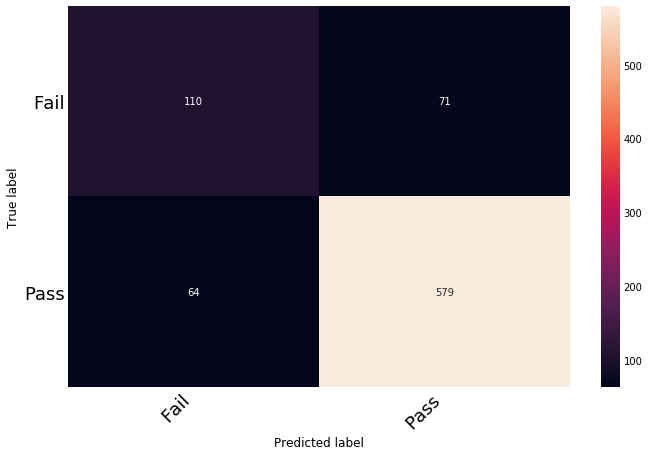

In [119]:
print('Test scores on original training set are:\n')
print('Accuracy score after ADASYN is:', colored(str(round(Random_Forest_ADASYN.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after ADASYN is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))
print('Precision score after ADASYN is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'green'))
print('F1 score after ADASYN is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_adasyn_cm = confusion_matrix(grade_label_train, Random_Forest_ADASYN.predict(feat_train))
RF_adasyn_cm = print_confusion_matrix(RF_adasyn_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Random Forest with ADASYN')

### So does Oversampling help?

In [120]:
mini_model_list = [Random_Forest, Random_Forest_ROS, Random_Forest_SMOTE, Random_Forest_ADASYN]
mini_model_names = ['RF', 'RF with ROS', 'RF with SMOTE', 'RF with ADASYN']

kfold = KFold(n_splits=10, random_state=42)
precision_scores = []
oversample_model_scores = []

for i in range(len(mini_model_list)):
    try_model = mini_model_list[i]
    for train_index, test_index in kfold.split(feat_train):
        kfeat_train = feat_train.iloc[train_index]
        kfeat_test = feat_train.iloc[test_index]
        kgrade_train = grade_label_train.iloc[train_index]
        kgrade_test = grade_label_train.iloc[test_index]
        
        precision = precision_score(kgrade_test, try_model.predict(kfeat_test))
        precision_scores.append(precision)
    oversample_model_scores.append((mini_model_names[i], round(np.mean(precision_scores), 3)))
    
for t in oversample_model_scores:
    print(t)

('RF', 0.928)
('RF with ROS', 0.919)
('RF with SMOTE', 0.912)
('RF with ADASYN', 0.906)


In [121]:
print('No oversampling precision score:', str(round(precision_score(grade_label_train, Random_Forest.predict(feat_train)), 3)))
print('With Random Oversampling precision score:', str(round(precision_score(grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)))
print('With SMOTE precision score:', str(round(precision_score(grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)))
print('With ADASYN precision score:', str(round(precision_score(grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)))

No oversampling precision score: 0.93
With Random Oversampling precision score: 0.91
With SMOTE precision score: 0.898
With ADASYN precision score: 0.891


> Shocker! This makes no sense

### Let's double check:

In [122]:
#Split the training set
X_train, X_test, y_train, y_test = train_test_split(feat_train, grade_label_train, test_size=0.3)

In [123]:
#Fit sample to one part of the training set
ADA = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = ADA.fit_sample(X_train, y_train)

#Fit the model with "adasyned" values
Random_Forest_ADASYN_test = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_ADASYN_test.fit(X_train_adasyn, y_train_adasyn);


Confusion Matrix for Random Forest with ADASYN


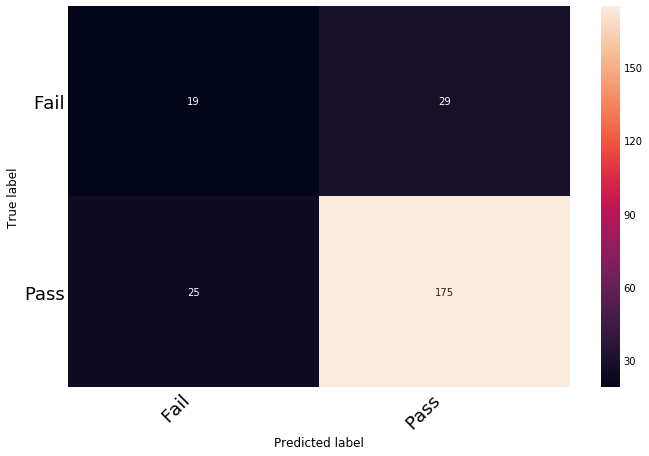

In [124]:
#Predict using the model trained on "adasyned" values
RF_adasyn_cm_test = confusion_matrix(y_test, Random_Forest_ADASYN_test.predict(X_test))
RF_adasyn_cm_test = print_confusion_matrix(RF_adasyn_cm_test, ['Fail', 'Pass'])


print('\nConfusion Matrix for Random Forest with ADASYN')


Confusion Matrix for Random Forest without Oversampling


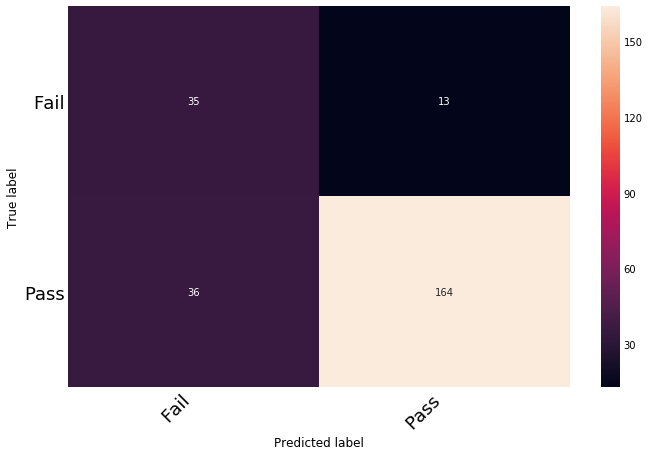

In [125]:
RF_cm = confusion_matrix(y_test, Random_Forest.predict(X_test))
RF_cm = print_confusion_matrix(RF_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Random Forest without Oversampling')

### Final oversampling sanity check

In [126]:
Naive_Bayes = BernoulliNB(alpha=0.1, fit_prior=False)
Naive_Bayes.fit(feat_train, grade_label_train);

Confusion Matrix for Naive Bayes (Bernoulli)


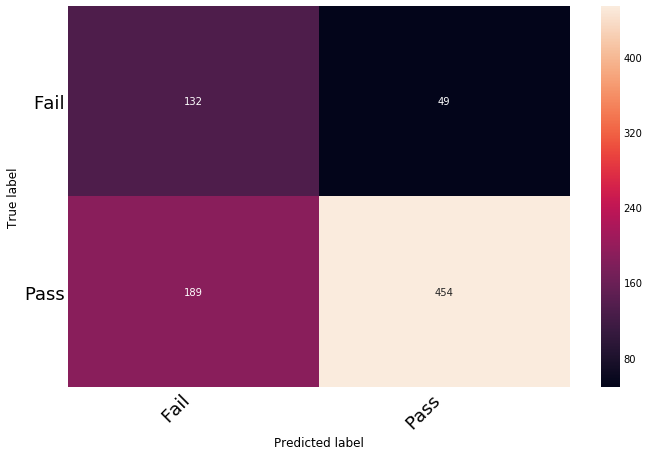

In [127]:
NBB_cm = confusion_matrix(grade_label_train, Naive_Bayes.predict(feat_train))
NBB_cm = print_confusion_matrix(NBB_cm, ['Fail', 'Pass'])

print('Confusion Matrix for Naive Bayes (Bernoulli)')

#### Random Over Sampler 

In [128]:
ROS = RandomOverSampler(random_state=42)
feat_train_ROS, grade_label_train_ROS = ROS.fit_sample(feat_train, grade_label_train)

In [129]:
Counter(grade_label_train_ROS)

Counter({1: 643, 0: 643})

In [130]:
#Create a new Random Forest model and fit with "oversampled" values
NBB_ROS = BernoulliNB(alpha=0.1, fit_prior=False)
NBB_ROS.fit(feat_train_ROS, grade_label_train_ROS);

The scores on original training set are:

Accuracy score after Random Over Sampler is: 0.757
Recall score after Random Over Sampler is: 0.795
Precision score after Random Over Sampler is: 0.883
F1 score after Random Over Sampler is: 0.836

Confusion Matrix for Naive Bayes with Random Oversampling


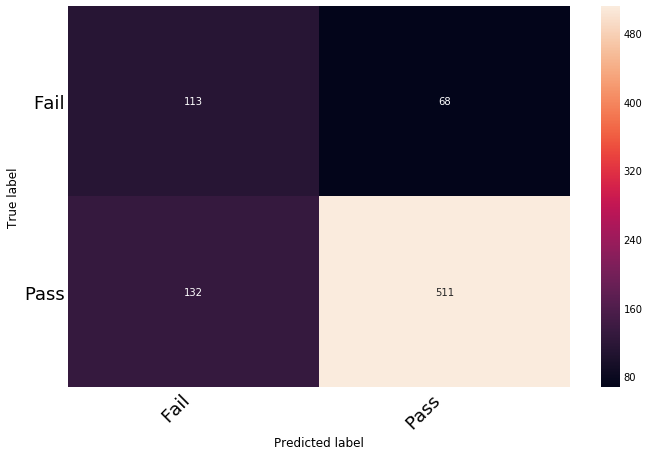

In [131]:
print('The scores on original training set are:\n')
print('Accuracy score after Random Over Sampler is:', colored(str(round(NBB_ROS.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after Random Over Sampler is:', colored(str(round(recall_score(
                                        grade_label_train, NBB_ROS.predict(feat_train)), 3)), 'magenta'))
print('Precision score after Random Over Sampler is:', colored(str(round(precision_score(
                                        grade_label_train, NBB_ROS.predict(feat_train)), 3)), 'green'))
print('F1 score after Random Over Sampler is:', colored(str(round(f1_score(
                                        grade_label_train, NBB_ROS.predict(feat_train)), 3)), 'magenta'))

NBB_ROS_cm = confusion_matrix(grade_label_train, NBB_ROS.predict(feat_train))
NBB_ROS_cm = print_confusion_matrix(NBB_ROS_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Naive Bayes with Random Oversampling')

#### SMOTE

In [132]:
SMO = SMOTE(random_state=42)
feat_train_smoted, grade_label_train_smoted = SMO.fit_sample(feat_train, grade_label_train)

In [133]:
Counter(grade_label_train_smoted)

Counter({1: 643, 0: 643})

In [134]:
NBB_SMOTE = BernoulliNB(alpha=0.1, fit_prior=False)
NBB_SMOTE.fit(feat_train_smoted, grade_label_train_smoted);

Test scores on original training set are:

Accuracy score after SMOTE is: 0.727
Recall score after SMOTE is: 0.742
Precision score after SMOTE is: 0.89
F1 score after SMOTE is: 0.809

Confusion Matrix for Naive Bayes with SMOTE


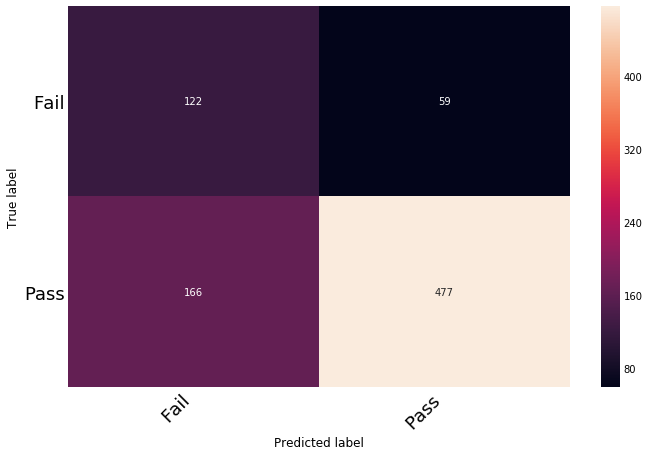

In [135]:
print('Test scores on original training set are:\n')
print('Accuracy score after SMOTE is:', colored(str(round(NBB_SMOTE.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after SMOTE is:', colored(str(round(recall_score(
                                        grade_label_train, NBB_SMOTE.predict(feat_train)), 3)), 'magenta'))
print('Precision score after SMOTE is:', colored(str(round(precision_score(
                                        grade_label_train, NBB_SMOTE.predict(feat_train)), 3)), 'green'))
print('F1 score after SMOTE is:', colored(str(round(f1_score(
                                        grade_label_train, NBB_SMOTE.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
NBB_smoted_cm = confusion_matrix(grade_label_train, NBB_SMOTE.predict(feat_train))
NBB_smoted_cm = print_confusion_matrix(NBB_smoted_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Naive Bayes with SMOTE')

> Not much improvement with SMOTE

#### ADASYN

In [136]:
ADA = ADASYN(random_state=42)
feat_train_adasyn, grade_label_train_adasyn = ADA.fit_sample(feat_train, grade_label_train)

In [137]:
Counter(grade_label_train_adasyn)

Counter({1: 643, 0: 648})

In [138]:
NBB_ADASYN = BernoulliNB(alpha=0.1, fit_prior=False)
NBB_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn);

Test scores on original training set are:

Accuracy score after ADASYN is: 0.762
Recall score after ADASYN is: 0.809
Precision score after ADASYN is: 0.877
F1 score after ADASYN is: 0.841

Confusion Matrix for Naive Bayes with ADASYN


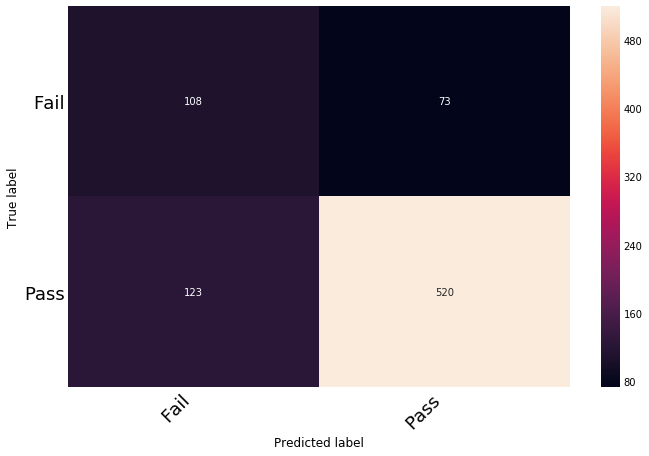

In [139]:
print('Test scores on original training set are:\n')
print('Accuracy score after ADASYN is:', colored(str(round(NBB_ADASYN.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after ADASYN is:', colored(str(round(recall_score(
                                        grade_label_train, NBB_ADASYN.predict(feat_train)), 3)), 'magenta'))
print('Precision score after ADASYN is:', colored(str(round(precision_score(
                                        grade_label_train, NBB_ADASYN.predict(feat_train)), 3)), 'green'))
print('F1 score after ADASYN is:', colored(str(round(f1_score(
                                        grade_label_train, NBB_ADASYN.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
NBB_adasyn_cm = confusion_matrix(grade_label_train, NBB_ADASYN.predict(feat_train))
NBB_adasyn_cm = print_confusion_matrix(NBB_adasyn_cm, ['Fail', 'Pass'])

print('\nConfusion Matrix for Naive Bayes with ADASYN')

## Feature selection (with Random Forest)

In [140]:
feat_imp = []
for var, imp in zip([f for f in feat_train.columns], Random_Forest.feature_importances_):
    feat_imp.append((var, round(imp, 3)))

for var, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(var)+':', str(imp))

failures: 0.212
discipline: 0.136
absences: 0.096
goout: 0.059
higher: 0.058
Fedu: 0.056
studytime: 0.048
famrel: 0.048
Walc: 0.048
Medu: 0.046
health: 0.045
freetime: 0.044
age: 0.043
paid: 0.032
address: 0.03


## The moment of truth

In [141]:
Random_Forest = RandomForestClassifier(n_estimators=150, class_weight='balanced', max_depth=20, min_samples_leaf=10, min_samples_split=2
                                       , random_state=42)
Random_Forest.fit(feat_train, grade_label_train)

predict_test = Random_Forest.predict(feat_test)
precision_score_on_test = precision_score(grade_label_test, predict_test)
auc_score_on_test = roc_auc_score(grade_label_test, predict_test)

print('The final precision score on the test data is:', colored(str(round(precision_score_on_test, 3)), 'magenta'))
print('The final AUC score on the test data is:', colored(str(round(auc_score_on_test, 3)), 'magenta'))

The final precision score on the test data is: 0.864
The final AUC score on the test data is: 0.672


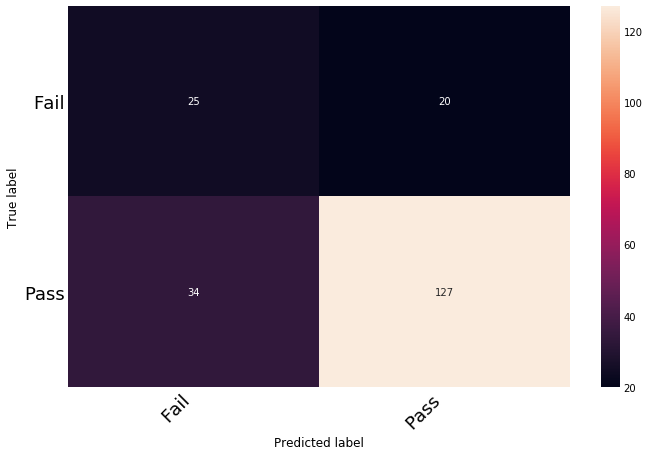

In [142]:
#What's my confusion matrix looking like?
final_CM = confusion_matrix(grade_label_test, Random_Forest.predict(feat_test))
final_CM = print_confusion_matrix(final_CM, ['Fail', 'Pass'])

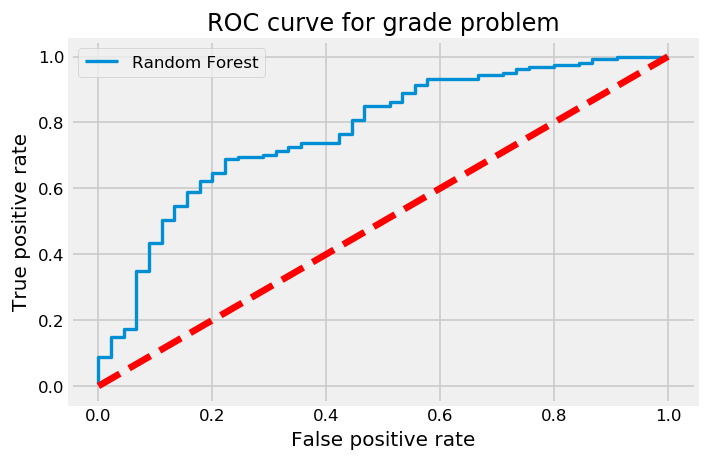

In [143]:
#Let's have a look at the ROC curve
fpr_RF, tpr_RF, thresholds_RF = roc_curve(grade_label_test, Random_Forest.predict_proba(feat_test)[:,1])
plt.figure(dpi=120)
plt.plot(fpr_RF, tpr_RF, lw=2, label='Random Forest')
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for grade problem');

> Could be worse! :D

### Time for retraining the model on the whole dataset

In [145]:
Random_Forest.fit(feat, grade_label)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## Let's pickle the model in prep for production

In [149]:
with open('Student_Grade_Predictor.pkl', 'wb') as my_pickle:
    pickle.dump(Random_Forest, my_pickle)

In [150]:
with open('Student_Grade_Predictor.pkl', 'rb') as my_pickle:
    Student_Grade_Predictor = pickle.load(my_pickle)

### Testing time

In [230]:
test_student = {'age': 15, 'address': 'U', 'Medu': 4, 'Fedu': 4, 'studytime': 5, 'failures': 1, 'paid': 0, 'higher': 1, 
               'famrel': 4, 'freetime': 5, 'goout': 1, 'Walc': 1, 'health': 5, 'absences': 10, 'discipline': 'maths'}

In [231]:
def make_prediction(features):
    feat_space = np.array([features['age'], int(features['address'] == 'U'), features['Medu'], features['Fedu'], features['studytime'],
                           features['failures'], features['paid'], features['higher'], features['famrel'], features['freetime'], 
                           features['goout'], features['Walc'], features['health'], features['absences'], 
                           int(features['discipline'] == 'maths')]).reshape(1,-1)
    
    prob_pass = round(Random_Forest.predict_proba(feat_space)[0, 1] * 100, 0)
    
    result = {
        'prediction': int(prob_pass > 50),
        'prob_pass': prob_pass
    }
    return result

make_prediction(test_student)

{'prediction': 1, 'prob_pass': 51.0}